Author: Nguyen Thi Thu Hang

#Logistic Regression with Pytorch

In this code, I will hands on Machine Learning coding skill with Linear Regression. The dataset is used in this project is advertising.csv with 5 features [Sepal_Length,	Sepal_Width, Petal_Length, Petal_Width, Label]. Specifically, 4 features are Sepal_Length,	Sepal_Width, Petal_Length, Petal_Width and label is Label.



In [1]:
!git clone https://github.com/NT-ThuHang/Hands_On_Machine_Learning_With_Pytorch.git
%cd /content/Hands_On_Machine_Learning_With_Pytorch

fatal: destination path 'Hands_On_Machine_Learning_With_Pytorch' already exists and is not an empty directory.
/content/Hands_On_Machine_Learning_With_Pytorch


## Logistic Regression

###1) When Logistic Regression can be used?  
---
**Logistic regression** can be used in classification problems where the output or dependent variable is categorical or binary. However, in order to implement logistic regression correctly, the dataset must also satisfy the following properties:

+ There should not be a high correlation between the independent variables. In other words, the predictor variables should be independent of each other.
+ There should be a linear relationship between the $logit$ of the outcome and each predictor variable. The $logit$ function is given as $logit(p) = \log(p/(1-p))$, where $p$ is the probability of the outcome.
+ The sample size must be large. How large depends on the number of independent variables of the model.

When all the requirements above are satisfied, logistic regression can be used.

### 2)  Why is Logistic Regression called Regression and not Classification? 
---
Although the task we are targeting in logistic regression is a classification, logistic regression does not actually individually classify things for you: it just gives you probabilities (or log odds ratios in the logit form).

The only way logistic regression can actually classify stuff is if you apply a rule to the probability output. For example, you may round probabilities greater than or equal to $50\%$ to 1, and probabilities less than $50\%$ to 0, and that’s your classification.

### 3)  What is a Decision Boundary?
---
A decision boundary is a line or a hyperplane that separates the classes. This is what we expect to obtain from logistic regression, as with any other classifier. With this, we can figure out some way to split the data to allow for an accurate prediction of a given observation’s class using the available information.

In the case of a generic two-dimensional example, the split might look something like this:
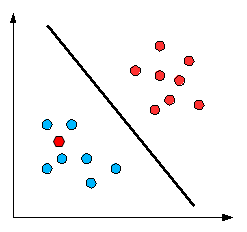

##Library

In [115]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

#Modeling
from torch import nn
from torch import optim
from tqdm import tqdm

#Evaluate
from sklearn.metrics import classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Load Dataset

In [3]:
dataset = pd.read_csv("./Dataset/iris_full.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sepal_Length   100 non-null    float64
 1    Sepal_Width   100 non-null    float64
 2    Petal_Length  100 non-null    float64
 3    Petal_Width   100 non-null    float64
 4    Label         100 non-null    float64
dtypes: float64(5)
memory usage: 4.0 KB


##Prepare Data

### Split data

In [4]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Scale 

In [104]:
scaler = StandardScaler()
X_train_scl = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float).to(device)
X_test_scl = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float).to(device)
y_train = torch.tensor(y_train, dtype = torch.float).to(device)
y_test = torch.tensor(y_test, dtype = torch.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


### DataLoader

In [105]:
class IrisDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.size()[0]

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

In [106]:
batch_size = 4
train_loader = DataLoader(IrisDataset(X_train_scl, y_train), batch_size=batch_size, shuffle=True)

##Modeling

In [107]:
class LogisticRegression(nn.Module):
  def __init__(self, inputDim, outputDim):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(inputDim, outputDim)

  def forward(self, X):
    outputs = torch.sigmoid(self.linear(X))
    return outputs



In [108]:
class Config_Hyperparameters(object):
  def __init__(self):
    self.inputDim = dataset.shape[1]-1
    self.outputDim = 1

    self.lr = 1e-3
    self.epochs = 100

In [109]:
cfg = Config_Hyperparameters() 

model = LogisticRegression(cfg.inputDim, cfg.outputDim).to(device)
loss_func = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = cfg.lr)

##Training Phase

In [110]:
losses = []
accuracy = []
num_samples = X_train.shape[0]

for epoch in tqdm(range(int(cfg.epochs)),desc='Training Epochs'):
  correct = 0
  epoch_loss = 0
  # inner loop
  for i, (data, label) in enumerate(train_loader):
    #init grad to 0
    optimizer.zero_grad()

    #get samples
    data = data.to(device)
    labels = label.to(device)

    #forward 
    pro_pred = model(data)
    #compute loss
    loss = loss_func(torch.squeeze(pro_pred), labels)
    #backward()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    
    with torch.no_grad():
      label_predicted = torch.squeeze(pro_pred).round().cpu().detach().numpy()
      correct += np.sum(label_predicted == labels.cpu().detach().numpy())

  losses.append(epoch_loss/num_samples)
  accuracy.append(correct/num_samples)

  if (epoch%5==0 or epoch==cfg.epochs-1):
    print("\nEpoch {}, Loss: {}, Accuracy: {}".format(epoch, epoch_loss/num_samples, correct/num_samples))

  



Training Epochs:  12%|█▏        | 12/100 [00:00<00:01, 55.51it/s]


Epoch 0, Loss: 0.2391381122171879, Accuracy: 0.2375

Epoch 5, Loss: 0.21390308812260628, Accuracy: 0.2875

Epoch 10, Loss: 0.19196052327752114, Accuracy: 0.425


Training Epochs:  24%|██▍       | 24/100 [00:00<00:01, 52.29it/s]


Epoch 15, Loss: 0.17295607402920724, Accuracy: 0.4875

Epoch 20, Loss: 0.15651874728500842, Accuracy: 0.5875

Epoch 25, Loss: 0.14229652434587478, Accuracy: 0.7625


Training Epochs:  36%|███▌      | 36/100 [00:00<00:01, 52.27it/s]


Epoch 30, Loss: 0.12997455671429634, Accuracy: 0.8375

Epoch 35, Loss: 0.11926445551216602, Accuracy: 0.9625

Epoch 40, Loss: 0.10992231331765652, Accuracy: 0.9875


Training Epochs:  54%|█████▍    | 54/100 [00:01<00:00, 53.05it/s]


Epoch 45, Loss: 0.10174611620604992, Accuracy: 0.9875

Epoch 50, Loss: 0.09455181993544101, Accuracy: 0.9875

Epoch 55, Loss: 0.08820574693381786, Accuracy: 0.9875


Training Epochs:  72%|███████▏  | 72/100 [00:01<00:00, 54.52it/s]


Epoch 60, Loss: 0.08256882317364216, Accuracy: 0.9875

Epoch 65, Loss: 0.07754554748535156, Accuracy: 1.0

Epoch 70, Loss: 0.07304828353226185, Accuracy: 1.0


Training Epochs:  84%|████████▍ | 84/100 [00:01<00:00, 54.25it/s]


Epoch 75, Loss: 0.06901033204048872, Accuracy: 1.0

Epoch 80, Loss: 0.06536436844617129, Accuracy: 1.0

Epoch 85, Loss: 0.06206495855003595, Accuracy: 1.0


Training Epochs: 100%|██████████| 100/100 [00:01<00:00, 53.49it/s]


Epoch 90, Loss: 0.05906387232244015, Accuracy: 1.0

Epoch 95, Loss: 0.05632663499563932, Accuracy: 1.0

Epoch 99, Loss: 0.054305430874228476, Accuracy: 1.0


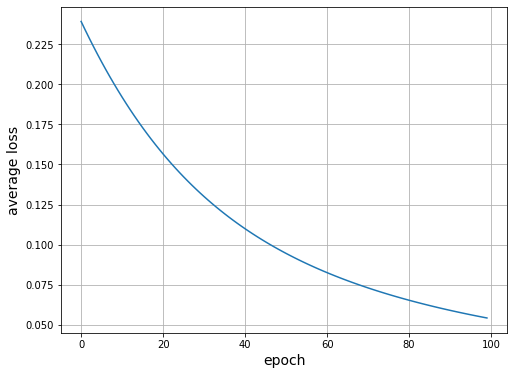

In [111]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()

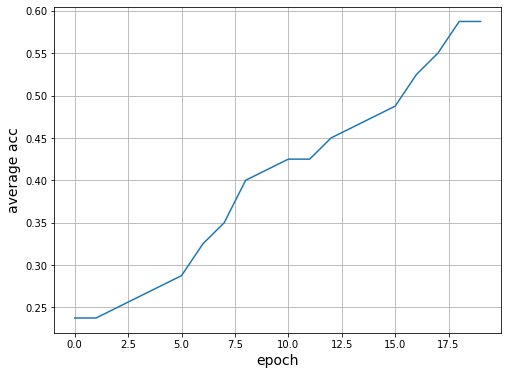

In [112]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(accuracy[:20])

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average acc', fontsize=14)
plt.show()

#Testing Phase

In [118]:
with torch.no_grad():
  predict = torch.squeeze(model(X_test_scl)).round().cpu().detach().numpy()
  print(classification_report(predict, y_test.cpu().detach().numpy()))



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

